In [10]:
import torch
import torch.nn as nn
import pathlib
import numpy as np
import torchvision.transforms as transforms
import os
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import cv2

from tqdm import tqdm as tqdm
from simclr import SimCLR
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from flash.core.optimizers import LARS
from scipy.stats import ortho_group

from torch.utils.tensorboard import SummaryWriter
from simclr.modules.transformations import TransformsSimCLR
from simclr.modules import NT_Xent

from typing import Callable, Iterator, Dict
from torch import linalg as LA
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torchvision
from simclr.modules import LogisticRegression

patch_typeguard()  # use before @typechecked



In [20]:
image_size = 448
batch_size = 32
global_step = 0
epochs = 50
temperature = 0.2
projection_dim = 64
resnet = 'resnet18'
lr = 0.075 * np.sqrt(batch_size)
weight_decay = 1e-6
model_path = "logs"
epoch_num = 100
logistic_epochs = 500

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [21]:
# To make it work in both Jupyter and standalone:
if "__file__" in globals():
    root = pathlib.Path(__file__).parent.resolve()
else:
    # Probably running interactively; in Jupyter, notebook path is
    # typically 'os.getcwd()', if it's not that's where we are going
    # to store the CIFAR data.
    root = pathlib.Path(os.getcwd())
    
    
train_dataset = CIFAR10(root=root, download=True, transform = TransformsSimCLR(size = image_size))
torch.manual_seed(43)
train_loader = DataLoader(train_dataset, 
                          batch_size, 
                          shuffle=False,
                          drop_last = True,
                          num_workers=2,
                          sampler = None)
test_dataset = torchvision.datasets.CIFAR10(
        root,
        train=False,
        download=True,
        transform=TransformsSimCLR(size=image_size).test_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
encoder = torch.hub.load('pytorch/vision:v0.10.0', resnet, pretrained=False) 
n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
model = SimCLR(encoder, projection_dim, n_features).to(DEVICE)

Using cache found in C:\Users\Shulu/.cache\torch\hub\pytorch_vision_v0.10.0


In [15]:
optimizer = LARS(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = NT_Xent(batch_size, temperature = temperature, world_size=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       epochs, 
                                                       eta_min=0, 
                                                       last_epoch=-1)

In [16]:
@typechecked
def random_ortho_matrix_gen(dim_a: int, dim_b: int) -> Iterator[TensorType["dim_a", "dim_b"]]:
    assert dim_a >= dim_b, f"Assuming we want projection matrices (broad and short), got dims {dim_a} x {dim_b}"
    while True:
        m = ortho_group.rvs(dim=dim_a)
        for i in range(dim_a // dim_b):
            yield torch.Tensor(m[i*dim_b : (i+1)*dim_b])

@typechecked
def prior_sampler(name: str, batch_size: int, feature_dim: int) -> Callable[[], 
                                                                            TensorType["batch_size", "feature_dim"]]:
    """
    Constructs a sampling function from a named distribution. E.g., with `name=="Uniform hypersphere"`, 
    the resulting function samples `batch_size` vectors of length `feature_dim` on a uniform hypersphere.
    """
    @typechecked
    def hypersphere_sampler() -> TensorType['batch_size', 'feature_dim']:
        X = torch.normal(mean=0, std=1, size=(batch_size, feature_dim))
        return X / LA.norm(X, dim=1).unsqueeze(1)
    
    d : Dict[str,  Callable[[], TensorType["batch_size", "feature_dim"]]] = {
         "Uniform hypersphere": hypersphere_sampler, 
         "Uniform hypercube": lambda: torch.rand(size=(batch_size, feature_dim)),
         "Normal distribution": lambda: torch.normal(mean=0, std=1, size=(batch_size, feature_dim)),
        }
    if name not in d:
        raise ValueError(f"Distr '{name}' not in {d.keys()}")
    
    return d[name]

class SWD_contrastiveloss(nn.Module):
    @typechecked
    def __init__(self, batch_size: int, feature_dim: int, prior_name: str,
                 normalize_before_align: bool = True,
                 SWD_dim: int=-1, SWD_lambda: float = 1.):
        super(SWD_contrastiveloss, self).__init__()
        self.batch_size = batch_size
        self.feature_dim = feature_dim
        #self.temperature = temperature
        self.normalize_before_align = normalize_before_align
        self.sample_prior = prior_sampler(prior_name, batch_size=2*batch_size, feature_dim=feature_dim)
        self.ortho_matrix_gen = random_ortho_matrix_gen(feature_dim, SWD_dim)
        self.lmbda = SWD_lambda
        self.SWD_dim = SWD_dim
        
    @typechecked
    def forward(self, zi: TensorType["batch_size", "feature_dim"],
                zj: TensorType["batch_size", "feature_dim"]):
        # Following "Algorithm 1" in the paper
        n : int = self.batch_size
        d = zi.size(dim = -1)
        
        # Project zi/zj onto hypersphere (i.e. normalize).
        if self.normalize_before_align:
            zi = zi / LA.norm(zi, dim=1).unsqueeze(1)
            zj = zj / LA.norm(zj, dim=1).unsqueeze(1)
        loss_align = ((zi - zj)**2).sum() / (n*d)
        Z : TensorType[2*self.batch_size, self.feature_dim] = torch.cat((zi, zj), dim=0).to(DEVICE)
        P : TensorType[2*self.batch_size, self.feature_dim] = self.sample_prior().to(DEVICE)
        W : TensorType[self.feature_dim, self.SWD_dim] = next(self.ortho_matrix_gen).to(DEVICE)
        
        
        H_perp, P_perp = Z @ W, P @ W 
        #loss_distr = torch.Tensor(0.) #Getting compiler error if we do like that, solution done below.
        loss_distr = 0 #commented out torch.Tensor since we are supposed to get a singular value anyway.
        for j in range(self.SWD_dim):
            hj, pj = H_perp[:, j], P_perp[:, j]
            hj, _ = torch.sort(hj)
            pj, _ = torch.sort(pj)
            loss_distr = loss_distr + ((hj - pj)**2).sum()
        loss_distr = loss_distr / (self.feature_dim * self.SWD_dim)
        return loss_align + self.lmbda * loss_distr
    
swd_normal_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Normal distribution")
swd_cube_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypercube")
swd_sphere_crit = SWD_contrastiveloss(batch_size, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypersphere")


In [17]:
def train(global_step, loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for steps, ((x_i, x_j), _) in enumerate(loader):
        x_i = x_i.to(DEVICE)
        x_j = x_j.to(DEVICE)
        
        optimizer.zero_grad()
        h_i, h_j, z_i, z_j = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        if steps % 50 == 0:
            print(f"Step [{steps}/{len(loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), global_step)
        loss_epoch += loss.item()
        global_step += 1
    return loss_epoch

In [9]:
for epoch in tqdm(range(epochs)):
    loss_epoch = train(global_step, train_loader, model, criterion, optimizer, writer)
    scheduler.step()
    writer.add_scalar("Loss/train", loss_epoch / len(train_loader), epoch)
    print(
        f"Epoch [{epoch}/{epochs}]\t Loss: {loss_epoch / len(train_loader)}\t"
    )

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Step [0/1562]	 Loss: 4.095876216888428
Step [50/1562]	 Loss: 4.055898666381836
Step [100/1562]	 Loss: 4.034712314605713
Step [150/1562]	 Loss: 3.6439249515533447
Step [200/1562]	 Loss: 3.5633552074432373
Step [250/1562]	 Loss: 3.7546260356903076
Step [300/1562]	 Loss: 3.906881809234619
Step [350/1562]	 Loss: 3.731212854385376
Step [400/1562]	 Loss: 3.578831195831299
Step [450/1562]	 Loss: 3.4836575984954834
Step [500/1562]	 Loss: 3.893601417541504
Step [550/1562]	 Loss: 3.7161519527435303
Step [600/1562]	 Loss: 3.9585039615631104
Step [650/1562]	 Loss: 3.5748541355133057
Step [700/1562]	 Loss: 3.6089541912078857
Step [750/1562]	 Loss: 3.6622397899627686
Step [800/1562]	 Loss: 3.882746458053589
Step [850/1562]	 Loss: 3.406280994415283
Step [900/1562]	 Loss: 3.5377209186553955
Step [950/1562]	 Loss: 3.5786895751953125
Step [1000/1562]	 Loss: 3.6173789501190186
Step [1050/1562]	 Loss: 3.557499647140503
Step [1100/1562]	 Loss: 3.812763214111328
Step [1150/1562]	 Loss: 3.5149426460266113
St

  2%|█▌                                                                              | 1/50 [07:02<5:45:10, 422.66s/it]

Epoch [0/50]	 Loss: 3.65097932962083	
Step [0/1562]	 Loss: 3.6750693321228027
Step [50/1562]	 Loss: 3.361114978790283
Step [100/1562]	 Loss: 3.4287383556365967
Step [150/1562]	 Loss: 3.3603131771087646
Step [200/1562]	 Loss: 3.341007709503174
Step [250/1562]	 Loss: 3.0564181804656982
Step [300/1562]	 Loss: 3.8544321060180664
Step [350/1562]	 Loss: 3.2807857990264893
Step [400/1562]	 Loss: 3.1200294494628906
Step [450/1562]	 Loss: 3.358917236328125
Step [500/1562]	 Loss: 3.267702102661133
Step [550/1562]	 Loss: 3.2272651195526123
Step [600/1562]	 Loss: 2.8633675575256348
Step [650/1562]	 Loss: 3.4714162349700928
Step [700/1562]	 Loss: 3.223757266998291
Step [750/1562]	 Loss: 3.3281030654907227
Step [800/1562]	 Loss: 2.9912333488464355
Step [850/1562]	 Loss: 2.9057161808013916
Step [900/1562]	 Loss: 3.7189035415649414
Step [950/1562]	 Loss: 3.6453685760498047
Step [1000/1562]	 Loss: 3.650858163833618
Step [1050/1562]	 Loss: 3.790553331375122
Step [1100/1562]	 Loss: 3.1871793270111084
Ste

  4%|███▏                                                                            | 2/50 [14:02<5:36:34, 420.71s/it]

Epoch [1/50]	 Loss: 3.255850570149977	
Step [0/1562]	 Loss: 3.2139785289764404
Step [50/1562]	 Loss: 3.3795242309570312
Step [100/1562]	 Loss: 3.5331904888153076
Step [150/1562]	 Loss: 3.0487968921661377
Step [200/1562]	 Loss: 3.072465658187866
Step [250/1562]	 Loss: 3.029327869415283
Step [300/1562]	 Loss: 3.133104085922241
Step [350/1562]	 Loss: 2.7466108798980713
Step [400/1562]	 Loss: 3.2138819694519043
Step [450/1562]	 Loss: 2.7421343326568604
Step [500/1562]	 Loss: 2.91062593460083
Step [550/1562]	 Loss: 3.1001317501068115
Step [600/1562]	 Loss: 2.9863200187683105
Step [650/1562]	 Loss: 3.1651041507720947
Step [700/1562]	 Loss: 3.05135178565979
Step [750/1562]	 Loss: 2.9504637718200684
Step [800/1562]	 Loss: 3.036983013153076
Step [850/1562]	 Loss: 3.1325793266296387
Step [900/1562]	 Loss: 3.2473502159118652
Step [950/1562]	 Loss: 2.8563337326049805
Step [1000/1562]	 Loss: 2.79844069480896
Step [1050/1562]	 Loss: 2.582585334777832
Step [1100/1562]	 Loss: 3.0479209423065186
Step [

  6%|████▊                                                                           | 3/50 [21:01<5:29:00, 420.01s/it]

Epoch [2/50]	 Loss: 3.0075116073581536	
Step [0/1562]	 Loss: 3.0663363933563232
Step [50/1562]	 Loss: 2.943619728088379
Step [100/1562]	 Loss: 2.855705499649048
Step [150/1562]	 Loss: 2.575737237930298
Step [200/1562]	 Loss: 2.348741292953491
Step [250/1562]	 Loss: 2.675493001937866
Step [300/1562]	 Loss: 2.8390510082244873
Step [350/1562]	 Loss: 2.7835183143615723
Step [400/1562]	 Loss: 2.725616693496704
Step [450/1562]	 Loss: 2.9369218349456787
Step [500/1562]	 Loss: 3.138514995574951
Step [550/1562]	 Loss: 2.5768589973449707
Step [600/1562]	 Loss: 3.107449531555176
Step [650/1562]	 Loss: 2.3179421424865723
Step [700/1562]	 Loss: 2.9457359313964844
Step [750/1562]	 Loss: 2.7228987216949463
Step [800/1562]	 Loss: 2.526780605316162
Step [850/1562]	 Loss: 3.2839646339416504
Step [900/1562]	 Loss: 2.531991958618164
Step [950/1562]	 Loss: 2.629155158996582
Step [1000/1562]	 Loss: 2.975432872772217
Step [1050/1562]	 Loss: 2.978961706161499
Step [1100/1562]	 Loss: 2.235835313796997
Step [11

  8%|██████▍                                                                         | 4/50 [27:58<5:21:18, 419.10s/it]

Epoch [3/50]	 Loss: 2.8017405506590722	
Step [0/1562]	 Loss: 2.6795666217803955
Step [50/1562]	 Loss: 2.6116647720336914
Step [100/1562]	 Loss: 2.622469663619995
Step [150/1562]	 Loss: 2.6493420600891113
Step [200/1562]	 Loss: 2.7475922107696533
Step [250/1562]	 Loss: 2.641054630279541
Step [300/1562]	 Loss: 2.9389631748199463
Step [350/1562]	 Loss: 2.6755082607269287
Step [400/1562]	 Loss: 2.85427188873291
Step [450/1562]	 Loss: 2.6390485763549805
Step [500/1562]	 Loss: 2.577584981918335
Step [550/1562]	 Loss: 3.102999687194824
Step [600/1562]	 Loss: 2.6364336013793945
Step [650/1562]	 Loss: 2.269948720932007
Step [700/1562]	 Loss: 2.5978424549102783
Step [750/1562]	 Loss: 2.7296173572540283
Step [800/1562]	 Loss: 2.464465856552124
Step [850/1562]	 Loss: 2.7281999588012695
Step [900/1562]	 Loss: 2.4228477478027344
Step [950/1562]	 Loss: 2.511624574661255
Step [1000/1562]	 Loss: 2.4330921173095703
Step [1050/1562]	 Loss: 2.768450975418091
Step [1100/1562]	 Loss: 1.9725899696350098
Step

 10%|████████                                                                        | 5/50 [34:56<5:13:57, 418.62s/it]

Epoch [4/50]	 Loss: 2.622539457529974	
Step [0/1562]	 Loss: 2.7362148761749268
Step [50/1562]	 Loss: 2.8377456665039062
Step [100/1562]	 Loss: 2.73154616355896
Step [150/1562]	 Loss: 2.2512753009796143
Step [200/1562]	 Loss: 2.6059536933898926
Step [250/1562]	 Loss: 2.373853921890259
Step [300/1562]	 Loss: 2.5450146198272705
Step [350/1562]	 Loss: 2.09759259223938
Step [400/1562]	 Loss: 2.6682825088500977
Step [450/1562]	 Loss: 2.7989401817321777
Step [500/1562]	 Loss: 2.4433510303497314
Step [550/1562]	 Loss: 2.4428298473358154
Step [600/1562]	 Loss: 2.612236261367798
Step [650/1562]	 Loss: 2.4110565185546875
Step [700/1562]	 Loss: 2.3405849933624268
Step [750/1562]	 Loss: 2.676098585128784
Step [800/1562]	 Loss: 2.4012038707733154
Step [850/1562]	 Loss: 2.8456878662109375
Step [900/1562]	 Loss: 2.3807852268218994
Step [950/1562]	 Loss: 2.7159905433654785
Step [1000/1562]	 Loss: 2.264103889465332
Step [1050/1562]	 Loss: 2.488025426864624
Step [1100/1562]	 Loss: 2.3171613216400146
Step

 12%|█████████▌                                                                      | 6/50 [41:54<5:06:53, 418.49s/it]

Epoch [5/50]	 Loss: 2.502285353658141	
Step [0/1562]	 Loss: 2.521153450012207
Step [50/1562]	 Loss: 2.246826171875
Step [100/1562]	 Loss: 2.401212453842163
Step [150/1562]	 Loss: 2.8181989192962646
Step [200/1562]	 Loss: 2.2756600379943848
Step [250/1562]	 Loss: 2.1986398696899414
Step [300/1562]	 Loss: 2.2949745655059814
Step [350/1562]	 Loss: 2.1914281845092773
Step [400/1562]	 Loss: 2.246626138687134
Step [450/1562]	 Loss: 2.501828193664551
Step [500/1562]	 Loss: 2.2304112911224365
Step [550/1562]	 Loss: 2.2776193618774414
Step [600/1562]	 Loss: 2.550276279449463
Step [650/1562]	 Loss: 2.380577325820923
Step [700/1562]	 Loss: 2.5894527435302734
Step [750/1562]	 Loss: 2.3059282302856445
Step [800/1562]	 Loss: 2.662571907043457
Step [850/1562]	 Loss: 2.432051420211792
Step [900/1562]	 Loss: 2.239976644515991
Step [950/1562]	 Loss: 2.160283088684082
Step [1000/1562]	 Loss: 2.3405039310455322
Step [1050/1562]	 Loss: 2.2063539028167725
Step [1100/1562]	 Loss: 2.640972137451172
Step [1150

 14%|███████████▏                                                                    | 7/50 [48:51<4:59:28, 417.88s/it]

Epoch [6/50]	 Loss: 2.393972685944561	
Step [0/1562]	 Loss: 2.691906452178955
Step [50/1562]	 Loss: 2.220986843109131
Step [100/1562]	 Loss: 2.4094600677490234
Step [150/1562]	 Loss: 2.0442047119140625
Step [200/1562]	 Loss: 2.4995086193084717
Step [250/1562]	 Loss: 2.4689674377441406
Step [300/1562]	 Loss: 2.1737594604492188
Step [350/1562]	 Loss: 2.5464026927948
Step [400/1562]	 Loss: 2.336402416229248
Step [450/1562]	 Loss: 2.456430673599243
Step [500/1562]	 Loss: 2.2020206451416016
Step [550/1562]	 Loss: 2.399054765701294
Step [600/1562]	 Loss: 2.3525872230529785
Step [650/1562]	 Loss: 2.2224032878875732
Step [700/1562]	 Loss: 2.367717742919922
Step [750/1562]	 Loss: 1.8450897932052612
Step [800/1562]	 Loss: 2.375556707382202
Step [850/1562]	 Loss: 2.3921773433685303
Step [900/1562]	 Loss: 2.229807138442993
Step [950/1562]	 Loss: 2.4169554710388184
Step [1000/1562]	 Loss: 2.1519644260406494
Step [1050/1562]	 Loss: 2.537421464920044
Step [1100/1562]	 Loss: 2.1678106784820557
Step [1

 16%|████████████▊                                                                   | 8/50 [55:45<4:51:36, 416.57s/it]

Epoch [7/50]	 Loss: 2.295733212661499	
Step [0/1562]	 Loss: 2.284236192703247
Step [50/1562]	 Loss: 2.0009703636169434
Step [100/1562]	 Loss: 2.3626303672790527
Step [150/1562]	 Loss: 2.2067766189575195
Step [200/1562]	 Loss: 2.1864511966705322
Step [250/1562]	 Loss: 2.7976040840148926
Step [300/1562]	 Loss: 1.969358205795288
Step [350/1562]	 Loss: 2.184770345687866
Step [400/1562]	 Loss: 2.370490550994873
Step [450/1562]	 Loss: 2.337183713912964
Step [500/1562]	 Loss: 2.226973295211792
Step [550/1562]	 Loss: 1.9879720211029053
Step [600/1562]	 Loss: 2.0104455947875977
Step [650/1562]	 Loss: 2.3076884746551514
Step [700/1562]	 Loss: 2.270219564437866
Step [750/1562]	 Loss: 2.207038164138794
Step [800/1562]	 Loss: 1.7536497116088867
Step [850/1562]	 Loss: 2.3623485565185547
Step [900/1562]	 Loss: 2.1903321743011475
Step [950/1562]	 Loss: 2.8942959308624268
Step [1000/1562]	 Loss: 2.386995553970337
Step [1050/1562]	 Loss: 2.2692465782165527
Step [1100/1562]	 Loss: 2.2557218074798584
Step

 18%|██████████████                                                                | 9/50 [1:02:38<4:43:58, 415.58s/it]

Epoch [8/50]	 Loss: 2.226879019972304	
Step [0/1562]	 Loss: 2.1454901695251465
Step [50/1562]	 Loss: 2.3202009201049805
Step [100/1562]	 Loss: 1.9015207290649414
Step [150/1562]	 Loss: 2.0338125228881836
Step [200/1562]	 Loss: 2.1514201164245605
Step [250/1562]	 Loss: 2.2909626960754395
Step [300/1562]	 Loss: 2.4297828674316406
Step [350/1562]	 Loss: 2.267404317855835
Step [400/1562]	 Loss: 2.197127342224121
Step [450/1562]	 Loss: 2.112422466278076
Step [500/1562]	 Loss: 2.275407314300537
Step [550/1562]	 Loss: 2.2635369300842285
Step [600/1562]	 Loss: 2.134488344192505
Step [650/1562]	 Loss: 2.2666244506835938
Step [700/1562]	 Loss: 2.331181764602661
Step [750/1562]	 Loss: 2.4269049167633057
Step [800/1562]	 Loss: 1.9314043521881104
Step [850/1562]	 Loss: 2.1426851749420166
Step [900/1562]	 Loss: 2.5802266597747803
Step [950/1562]	 Loss: 2.262686014175415
Step [1000/1562]	 Loss: 2.191005229949951
Step [1050/1562]	 Loss: 2.0107579231262207
Step [1100/1562]	 Loss: 2.584599733352661
Step

 20%|███████████████▍                                                             | 10/50 [1:09:32<4:36:39, 414.98s/it]

Epoch [9/50]	 Loss: 2.158315071604774	
Step [0/1562]	 Loss: 1.9699660539627075
Step [50/1562]	 Loss: 2.162168025970459
Step [100/1562]	 Loss: 1.952344298362732
Step [150/1562]	 Loss: 2.0429532527923584
Step [200/1562]	 Loss: 2.2684779167175293
Step [250/1562]	 Loss: 2.248812198638916
Step [300/1562]	 Loss: 2.4982848167419434
Step [350/1562]	 Loss: 2.037174940109253
Step [400/1562]	 Loss: 1.6298725605010986
Step [450/1562]	 Loss: 2.493208169937134
Step [500/1562]	 Loss: 2.2208211421966553
Step [550/1562]	 Loss: 2.0307791233062744
Step [600/1562]	 Loss: 2.462648868560791
Step [650/1562]	 Loss: 2.0611050128936768
Step [700/1562]	 Loss: 2.254319667816162
Step [750/1562]	 Loss: 2.321432113647461
Step [800/1562]	 Loss: 2.0227153301239014
Step [850/1562]	 Loss: 2.081505060195923
Step [900/1562]	 Loss: 1.8802685737609863
Step [950/1562]	 Loss: 2.0942864418029785
Step [1000/1562]	 Loss: 1.8958555459976196
Step [1050/1562]	 Loss: 1.9777172803878784
Step [1100/1562]	 Loss: 2.2452378273010254
Step

 22%|████████████████▉                                                            | 11/50 [1:16:25<4:29:27, 414.54s/it]

Epoch [10/50]	 Loss: 2.1137373664162378	
Step [0/1562]	 Loss: 1.9527771472930908
Step [50/1562]	 Loss: 1.9309897422790527
Step [100/1562]	 Loss: 2.102794647216797
Step [150/1562]	 Loss: 2.1257846355438232
Step [200/1562]	 Loss: 2.0786688327789307
Step [250/1562]	 Loss: 2.132591485977173
Step [300/1562]	 Loss: 2.121149778366089
Step [350/1562]	 Loss: 1.9476325511932373
Step [400/1562]	 Loss: 2.2936224937438965
Step [450/1562]	 Loss: 2.053443193435669
Step [500/1562]	 Loss: 2.0063209533691406
Step [550/1562]	 Loss: 1.9140429496765137
Step [600/1562]	 Loss: 1.9969468116760254
Step [650/1562]	 Loss: 2.2690062522888184
Step [700/1562]	 Loss: 2.143889904022217
Step [750/1562]	 Loss: 1.9288785457611084
Step [800/1562]	 Loss: 1.7060413360595703
Step [850/1562]	 Loss: 2.234245777130127
Step [900/1562]	 Loss: 1.9011937379837036
Step [950/1562]	 Loss: 2.056389808654785
Step [1000/1562]	 Loss: 1.9422285556793213
Step [1050/1562]	 Loss: 2.0324788093566895
Step [1100/1562]	 Loss: 2.0653107166290283


 24%|██████████████████▍                                                          | 12/50 [1:23:19<4:22:24, 414.33s/it]

Epoch [11/50]	 Loss: 2.069836093506343	
Step [0/1562]	 Loss: 2.0492005348205566
Step [50/1562]	 Loss: 2.1372764110565186
Step [100/1562]	 Loss: 1.8333303928375244
Step [150/1562]	 Loss: 1.992194414138794
Step [200/1562]	 Loss: 2.0427744388580322
Step [250/1562]	 Loss: 1.956831932067871
Step [300/1562]	 Loss: 1.649478793144226
Step [350/1562]	 Loss: 2.3286359310150146
Step [400/1562]	 Loss: 1.810726284980774
Step [450/1562]	 Loss: 1.9548691511154175
Step [500/1562]	 Loss: 1.9202687740325928
Step [550/1562]	 Loss: 1.8611449003219604
Step [600/1562]	 Loss: 2.061187744140625
Step [650/1562]	 Loss: 1.8665298223495483
Step [700/1562]	 Loss: 2.0134778022766113
Step [750/1562]	 Loss: 1.5969102382659912
Step [800/1562]	 Loss: 1.837122917175293
Step [850/1562]	 Loss: 2.0618200302124023
Step [900/1562]	 Loss: 2.0362584590911865
Step [950/1562]	 Loss: 1.9283294677734375
Step [1000/1562]	 Loss: 2.106614112854004
Step [1050/1562]	 Loss: 1.8319371938705444
Step [1100/1562]	 Loss: 1.799791932106018
St

 26%|████████████████████                                                         | 13/50 [1:30:13<4:15:20, 414.08s/it]

Epoch [12/50]	 Loss: 2.0233664472948725	
Step [0/1562]	 Loss: 1.9886151552200317
Step [50/1562]	 Loss: 1.8845537900924683
Step [100/1562]	 Loss: 1.9460856914520264
Step [150/1562]	 Loss: 2.2895119190216064
Step [200/1562]	 Loss: 2.023719549179077
Step [250/1562]	 Loss: 1.8636635541915894
Step [300/1562]	 Loss: 1.7852357625961304
Step [350/1562]	 Loss: 2.027104377746582
Step [400/1562]	 Loss: 2.1375138759613037
Step [450/1562]	 Loss: 2.1239192485809326
Step [500/1562]	 Loss: 1.802391767501831
Step [550/1562]	 Loss: 1.8573161363601685
Step [600/1562]	 Loss: 1.9462857246398926
Step [650/1562]	 Loss: 2.0296928882598877
Step [700/1562]	 Loss: 1.7379242181777954
Step [750/1562]	 Loss: 1.778258204460144
Step [800/1562]	 Loss: 2.047255754470825
Step [850/1562]	 Loss: 2.4687507152557373
Step [900/1562]	 Loss: 1.5300722122192383
Step [950/1562]	 Loss: 1.917863368988037
Step [1000/1562]	 Loss: 1.5720596313476562
Step [1050/1562]	 Loss: 2.094966173171997
Step [1100/1562]	 Loss: 2.095292329788208
S

 28%|█████████████████████▌                                                       | 14/50 [1:37:06<4:08:17, 413.83s/it]

Epoch [13/50]	 Loss: 1.989176552213261	
Step [0/1562]	 Loss: 2.1892902851104736
Step [50/1562]	 Loss: 1.9382590055465698
Step [100/1562]	 Loss: 1.8186671733856201
Step [150/1562]	 Loss: 2.270341634750366
Step [200/1562]	 Loss: 2.0795350074768066
Step [250/1562]	 Loss: 2.0030405521392822
Step [300/1562]	 Loss: 1.8448593616485596
Step [350/1562]	 Loss: 1.9986119270324707
Step [400/1562]	 Loss: 2.0716311931610107
Step [450/1562]	 Loss: 2.0597097873687744
Step [500/1562]	 Loss: 1.7546613216400146
Step [550/1562]	 Loss: 2.0101020336151123
Step [600/1562]	 Loss: 2.117363691329956
Step [650/1562]	 Loss: 2.028028964996338
Step [700/1562]	 Loss: 1.7992509603500366
Step [750/1562]	 Loss: 1.8368481397628784
Step [800/1562]	 Loss: 1.7605425119400024
Step [850/1562]	 Loss: 1.9651097059249878
Step [900/1562]	 Loss: 1.9310029745101929
Step [950/1562]	 Loss: 2.193493127822876
Step [1000/1562]	 Loss: 2.2509145736694336
Step [1050/1562]	 Loss: 2.1952106952667236
Step [1100/1562]	 Loss: 1.730150341987609

 30%|███████████████████████                                                      | 15/50 [1:43:59<4:01:20, 413.72s/it]

Epoch [14/50]	 Loss: 1.9618126344741842	
Step [0/1562]	 Loss: 2.092298984527588
Step [50/1562]	 Loss: 2.5790598392486572
Step [100/1562]	 Loss: 2.127615213394165
Step [150/1562]	 Loss: 2.2304301261901855
Step [200/1562]	 Loss: 1.845088243484497
Step [250/1562]	 Loss: 2.0482590198516846
Step [300/1562]	 Loss: 1.9584951400756836
Step [350/1562]	 Loss: 1.9562301635742188
Step [400/1562]	 Loss: 1.9769978523254395
Step [450/1562]	 Loss: 2.2360146045684814
Step [500/1562]	 Loss: 1.8194444179534912
Step [550/1562]	 Loss: 1.8999121189117432
Step [600/1562]	 Loss: 1.6875557899475098
Step [650/1562]	 Loss: 2.205843448638916
Step [700/1562]	 Loss: 1.618850588798523
Step [750/1562]	 Loss: 1.8734909296035767
Step [800/1562]	 Loss: 1.4884461164474487
Step [850/1562]	 Loss: 1.832205891609192
Step [900/1562]	 Loss: 1.8203740119934082
Step [950/1562]	 Loss: 1.9075945615768433
Step [1000/1562]	 Loss: 1.6765873432159424
Step [1050/1562]	 Loss: 1.8986319303512573
Step [1100/1562]	 Loss: 1.8100467920303345

 32%|████████████████████████▋                                                    | 16/50 [1:50:53<3:54:25, 413.70s/it]

Epoch [15/50]	 Loss: 1.929373293771634	
Step [0/1562]	 Loss: 2.271411180496216
Step [50/1562]	 Loss: 2.2076287269592285
Step [100/1562]	 Loss: 1.9937094449996948
Step [150/1562]	 Loss: 1.8783742189407349
Step [200/1562]	 Loss: 1.6927145719528198
Step [250/1562]	 Loss: 1.983079195022583
Step [300/1562]	 Loss: 1.7602038383483887
Step [350/1562]	 Loss: 2.064739227294922
Step [400/1562]	 Loss: 1.9678773880004883
Step [450/1562]	 Loss: 1.955971121788025
Step [500/1562]	 Loss: 2.0779974460601807
Step [550/1562]	 Loss: 1.6573748588562012
Step [600/1562]	 Loss: 1.940595269203186
Step [650/1562]	 Loss: 1.7533085346221924
Step [700/1562]	 Loss: 2.058290481567383
Step [750/1562]	 Loss: 1.7592060565948486
Step [800/1562]	 Loss: 1.7219798564910889
Step [850/1562]	 Loss: 1.8161674737930298
Step [900/1562]	 Loss: 1.837441086769104
Step [950/1562]	 Loss: 1.823689341545105
Step [1000/1562]	 Loss: 1.7247850894927979
Step [1050/1562]	 Loss: 2.1029481887817383
Step [1100/1562]	 Loss: 1.5714094638824463
St

 34%|██████████████████████████▏                                                  | 17/50 [1:57:47<3:47:33, 413.73s/it]

Epoch [16/50]	 Loss: 1.9126643530080016	
Step [0/1562]	 Loss: 1.8641865253448486
Step [50/1562]	 Loss: 1.7069122791290283
Step [100/1562]	 Loss: 2.0168044567108154
Step [150/1562]	 Loss: 1.7148324251174927
Step [200/1562]	 Loss: 1.7905856370925903
Step [250/1562]	 Loss: 2.1342029571533203
Step [300/1562]	 Loss: 1.9476441144943237
Step [350/1562]	 Loss: 1.5427684783935547
Step [400/1562]	 Loss: 1.7780154943466187
Step [450/1562]	 Loss: 1.6477712392807007
Step [500/1562]	 Loss: 1.9836512804031372
Step [550/1562]	 Loss: 1.8992440700531006
Step [600/1562]	 Loss: 1.771669626235962
Step [650/1562]	 Loss: 1.6346139907836914
Step [700/1562]	 Loss: 1.76693594455719
Step [750/1562]	 Loss: 1.918803095817566
Step [800/1562]	 Loss: 1.7363468408584595
Step [850/1562]	 Loss: 1.9066290855407715
Step [900/1562]	 Loss: 1.8835629224777222
Step [950/1562]	 Loss: 1.8063738346099854
Step [1000/1562]	 Loss: 1.8886704444885254
Step [1050/1562]	 Loss: 2.0377559661865234
Step [1100/1562]	 Loss: 1.88949429988861

 36%|███████████████████████████▋                                                 | 18/50 [2:04:40<3:40:36, 413.64s/it]

Epoch [17/50]	 Loss: 1.885632892347939	
Step [0/1562]	 Loss: 2.0197300910949707
Step [50/1562]	 Loss: 2.0404903888702393
Step [100/1562]	 Loss: 2.0057804584503174
Step [150/1562]	 Loss: 1.9014713764190674
Step [200/1562]	 Loss: 1.774749517440796
Step [250/1562]	 Loss: 2.1788012981414795
Step [300/1562]	 Loss: 1.4331904649734497
Step [350/1562]	 Loss: 2.0317726135253906
Step [400/1562]	 Loss: 1.7539712190628052
Step [450/1562]	 Loss: 1.8331775665283203
Step [500/1562]	 Loss: 1.781810998916626
Step [550/1562]	 Loss: 1.7418183088302612
Step [600/1562]	 Loss: 1.8395830392837524
Step [650/1562]	 Loss: 1.7409530878067017
Step [700/1562]	 Loss: 1.85526704788208
Step [750/1562]	 Loss: 1.7223589420318604
Step [800/1562]	 Loss: 1.7619057893753052
Step [850/1562]	 Loss: 1.8849295377731323
Step [900/1562]	 Loss: 1.783276915550232
Step [950/1562]	 Loss: 1.8104785680770874
Step [1000/1562]	 Loss: 1.999589204788208
Step [1050/1562]	 Loss: 1.9058548212051392
Step [1100/1562]	 Loss: 1.7516826391220093


 38%|█████████████████████████████▎                                               | 19/50 [2:11:34<3:33:41, 413.59s/it]

Epoch [18/50]	 Loss: 1.8656586045339685	
Step [0/1562]	 Loss: 1.900006890296936
Step [50/1562]	 Loss: 1.9859830141067505
Step [100/1562]	 Loss: 1.7451210021972656
Step [150/1562]	 Loss: 1.7758235931396484
Step [200/1562]	 Loss: 1.7874126434326172
Step [250/1562]	 Loss: 1.6617255210876465
Step [300/1562]	 Loss: 1.761399745941162
Step [350/1562]	 Loss: 1.76426100730896
Step [400/1562]	 Loss: 1.6463429927825928
Step [450/1562]	 Loss: 1.9623910188674927
Step [500/1562]	 Loss: 1.968644380569458
Step [550/1562]	 Loss: 1.9739233255386353
Step [600/1562]	 Loss: 1.8282588720321655
Step [650/1562]	 Loss: 2.0274481773376465
Step [700/1562]	 Loss: 1.6643537282943726
Step [750/1562]	 Loss: 1.9304834604263306
Step [800/1562]	 Loss: 1.6172001361846924
Step [850/1562]	 Loss: 1.7813056707382202
Step [900/1562]	 Loss: 1.7267708778381348
Step [950/1562]	 Loss: 1.746943473815918
Step [1000/1562]	 Loss: 1.5626064538955688
Step [1050/1562]	 Loss: 2.3308258056640625
Step [1100/1562]	 Loss: 2.172997236251831


 40%|██████████████████████████████▊                                              | 20/50 [2:18:28<3:26:49, 413.64s/it]

Epoch [19/50]	 Loss: 1.8408310437019288	
Step [0/1562]	 Loss: 1.6079447269439697
Step [50/1562]	 Loss: 1.862463116645813
Step [100/1562]	 Loss: 1.544463872909546
Step [150/1562]	 Loss: 1.694216012954712
Step [200/1562]	 Loss: 2.0179100036621094
Step [250/1562]	 Loss: 2.0615742206573486
Step [300/1562]	 Loss: 1.8255325555801392
Step [350/1562]	 Loss: 1.6765377521514893
Step [400/1562]	 Loss: 2.1132054328918457
Step [450/1562]	 Loss: 2.2080743312835693
Step [500/1562]	 Loss: 1.923643946647644
Step [550/1562]	 Loss: 1.727245569229126
Step [600/1562]	 Loss: 1.9139747619628906
Step [650/1562]	 Loss: 1.7150871753692627
Step [700/1562]	 Loss: 1.7701013088226318
Step [750/1562]	 Loss: 1.7898287773132324
Step [800/1562]	 Loss: 1.7998329401016235
Step [850/1562]	 Loss: 2.0818443298339844
Step [900/1562]	 Loss: 1.6165430545806885
Step [950/1562]	 Loss: 1.986456036567688
Step [1000/1562]	 Loss: 1.5968598127365112
Step [1050/1562]	 Loss: 1.8509962558746338
Step [1100/1562]	 Loss: 1.8348814249038696

 42%|████████████████████████████████▎                                            | 21/50 [2:25:21<3:19:51, 413.52s/it]

Epoch [20/50]	 Loss: 1.8281897627742587	
Step [0/1562]	 Loss: 1.7608122825622559
Step [50/1562]	 Loss: 1.743220567703247
Step [100/1562]	 Loss: 1.604503870010376
Step [150/1562]	 Loss: 2.0032222270965576
Step [200/1562]	 Loss: 1.507139801979065
Step [250/1562]	 Loss: 1.7628546953201294
Step [300/1562]	 Loss: 1.6282975673675537
Step [350/1562]	 Loss: 1.9137661457061768
Step [400/1562]	 Loss: 1.922766089439392
Step [450/1562]	 Loss: 2.2634477615356445
Step [500/1562]	 Loss: 1.761765956878662
Step [550/1562]	 Loss: 1.8878697156906128
Step [600/1562]	 Loss: 1.5775796175003052
Step [650/1562]	 Loss: 1.7497001886367798
Step [700/1562]	 Loss: 1.7549761533737183
Step [750/1562]	 Loss: 2.000131130218506
Step [800/1562]	 Loss: 1.3097288608551025
Step [850/1562]	 Loss: 1.8048396110534668
Step [900/1562]	 Loss: 1.7589452266693115
Step [950/1562]	 Loss: 1.8796472549438477
Step [1000/1562]	 Loss: 1.6640735864639282
Step [1050/1562]	 Loss: 1.5997782945632935
Step [1100/1562]	 Loss: 1.7475336790084839

 44%|█████████████████████████████████▉                                           | 22/50 [2:32:14<3:12:58, 413.51s/it]

Epoch [21/50]	 Loss: 1.808629016412205	
Step [0/1562]	 Loss: 1.8856749534606934
Step [50/1562]	 Loss: 1.6603032350540161
Step [100/1562]	 Loss: 1.9222968816757202
Step [150/1562]	 Loss: 1.796595811843872
Step [200/1562]	 Loss: 1.8945605754852295
Step [250/1562]	 Loss: 1.9689812660217285
Step [300/1562]	 Loss: 1.6617735624313354
Step [350/1562]	 Loss: 2.0965845584869385
Step [400/1562]	 Loss: 1.9768927097320557
Step [450/1562]	 Loss: 1.7432615756988525
Step [500/1562]	 Loss: 1.6255685091018677
Step [550/1562]	 Loss: 1.531700611114502
Step [600/1562]	 Loss: 1.8311219215393066
Step [650/1562]	 Loss: 1.7765787839889526
Step [700/1562]	 Loss: 2.081355571746826
Step [750/1562]	 Loss: 1.8537949323654175
Step [800/1562]	 Loss: 1.5763046741485596
Step [850/1562]	 Loss: 1.633759617805481
Step [900/1562]	 Loss: 1.7424800395965576
Step [950/1562]	 Loss: 1.8045527935028076
Step [1000/1562]	 Loss: 1.6037383079528809
Step [1050/1562]	 Loss: 1.7714354991912842
Step [1100/1562]	 Loss: 1.670298099517822

 46%|███████████████████████████████████▍                                         | 23/50 [2:39:07<3:06:01, 413.40s/it]

Epoch [22/50]	 Loss: 1.7951941189478973	
Step [0/1562]	 Loss: 1.811142921447754
Step [50/1562]	 Loss: 1.6250618696212769
Step [100/1562]	 Loss: 1.5825815200805664
Step [150/1562]	 Loss: 1.8500319719314575
Step [200/1562]	 Loss: 1.795885443687439
Step [250/1562]	 Loss: 1.8520464897155762
Step [300/1562]	 Loss: 1.904443383216858
Step [350/1562]	 Loss: 1.985234260559082
Step [400/1562]	 Loss: 1.4820917844772339
Step [450/1562]	 Loss: 1.8596491813659668
Step [500/1562]	 Loss: 1.3389729261398315
Step [550/1562]	 Loss: 1.615371584892273
Step [600/1562]	 Loss: 1.5859867334365845
Step [650/1562]	 Loss: 1.5767842531204224
Step [700/1562]	 Loss: 2.048393487930298
Step [750/1562]	 Loss: 1.710257649421692
Step [800/1562]	 Loss: 1.520185112953186
Step [850/1562]	 Loss: 1.8691121339797974
Step [900/1562]	 Loss: 1.8299529552459717
Step [950/1562]	 Loss: 1.9822072982788086
Step [1000/1562]	 Loss: 1.7336292266845703
Step [1050/1562]	 Loss: 2.056300640106201
Step [1100/1562]	 Loss: 1.9646458625793457
St

 48%|████████████████████████████████████▉                                        | 24/50 [2:46:01<2:59:09, 413.43s/it]

Epoch [23/50]	 Loss: 1.7772062969574092	
Step [0/1562]	 Loss: 1.8787810802459717
Step [50/1562]	 Loss: 1.6850216388702393
Step [100/1562]	 Loss: 1.8902587890625
Step [150/1562]	 Loss: 2.1513094902038574
Step [200/1562]	 Loss: 1.4276517629623413
Step [250/1562]	 Loss: 1.9345721006393433
Step [300/1562]	 Loss: 1.8070555925369263
Step [350/1562]	 Loss: 1.686244010925293
Step [400/1562]	 Loss: 1.890514612197876
Step [450/1562]	 Loss: 2.055202007293701
Step [500/1562]	 Loss: 1.6473848819732666
Step [550/1562]	 Loss: 1.4955402612686157
Step [600/1562]	 Loss: 1.828636646270752
Step [650/1562]	 Loss: 1.964797854423523
Step [700/1562]	 Loss: 1.660740852355957
Step [750/1562]	 Loss: 1.6503803730010986
Step [800/1562]	 Loss: 1.467736840248108
Step [850/1562]	 Loss: 1.5803014039993286
Step [900/1562]	 Loss: 1.5237462520599365
Step [950/1562]	 Loss: 1.896128535270691
Step [1000/1562]	 Loss: 1.6602951288223267
Step [1050/1562]	 Loss: 1.8132374286651611
Step [1100/1562]	 Loss: 1.8493843078613281
Step

 50%|██████████████████████████████████████▌                                      | 25/50 [2:52:54<2:52:14, 413.37s/it]

Epoch [24/50]	 Loss: 1.7706358742622346	
Step [0/1562]	 Loss: 2.188110113143921
Step [50/1562]	 Loss: 2.128350019454956
Step [100/1562]	 Loss: 1.5607779026031494
Step [150/1562]	 Loss: 2.0078439712524414
Step [200/1562]	 Loss: 1.856959581375122
Step [250/1562]	 Loss: 1.7887121438980103
Step [300/1562]	 Loss: 1.9777652025222778
Step [350/1562]	 Loss: 1.7905285358428955
Step [400/1562]	 Loss: 1.710269570350647
Step [450/1562]	 Loss: 1.649034857749939
Step [500/1562]	 Loss: 1.583372712135315
Step [550/1562]	 Loss: 1.8422775268554688
Step [600/1562]	 Loss: 1.8984780311584473
Step [650/1562]	 Loss: 1.4758899211883545
Step [700/1562]	 Loss: 1.8709871768951416
Step [750/1562]	 Loss: 2.0342371463775635
Step [800/1562]	 Loss: 1.3687758445739746
Step [850/1562]	 Loss: 2.1434993743896484
Step [900/1562]	 Loss: 2.1693572998046875
Step [950/1562]	 Loss: 1.7467918395996094
Step [1000/1562]	 Loss: 1.6351088285446167
Step [1050/1562]	 Loss: 1.7012622356414795
Step [1100/1562]	 Loss: 1.8256704807281494

 52%|████████████████████████████████████████                                     | 26/50 [2:59:48<2:45:20, 413.37s/it]

Epoch [25/50]	 Loss: 1.761160484883605	
Step [0/1562]	 Loss: 1.4637320041656494
Step [50/1562]	 Loss: 1.4944431781768799
Step [100/1562]	 Loss: 1.8112248182296753
Step [150/1562]	 Loss: 1.7772098779678345
Step [200/1562]	 Loss: 1.6320996284484863
Step [250/1562]	 Loss: 1.9738776683807373
Step [300/1562]	 Loss: 1.9635218381881714
Step [350/1562]	 Loss: 1.9909286499023438
Step [400/1562]	 Loss: 1.781583309173584
Step [450/1562]	 Loss: 1.833907961845398
Step [500/1562]	 Loss: 1.8751976490020752
Step [550/1562]	 Loss: 1.510497808456421
Step [600/1562]	 Loss: 1.4183155298233032
Step [650/1562]	 Loss: 1.6159602403640747
Step [700/1562]	 Loss: 2.156423807144165
Step [750/1562]	 Loss: 1.906695008277893
Step [800/1562]	 Loss: 2.0356545448303223
Step [850/1562]	 Loss: 1.8464858531951904
Step [900/1562]	 Loss: 1.7176992893218994
Step [950/1562]	 Loss: 2.0043258666992188
Step [1000/1562]	 Loss: 1.7319062948226929
Step [1050/1562]	 Loss: 1.775258183479309
Step [1100/1562]	 Loss: 1.8727059364318848


 54%|█████████████████████████████████████████▌                                   | 27/50 [3:06:41<2:38:28, 413.42s/it]

Epoch [26/50]	 Loss: 1.7440102823870436	
Step [0/1562]	 Loss: 1.7112557888031006
Step [50/1562]	 Loss: 1.719376802444458
Step [100/1562]	 Loss: 1.730617642402649
Step [150/1562]	 Loss: 1.865928292274475
Step [200/1562]	 Loss: 1.4813545942306519
Step [250/1562]	 Loss: 1.8268821239471436
Step [300/1562]	 Loss: 1.8535490036010742
Step [350/1562]	 Loss: 1.8381741046905518
Step [400/1562]	 Loss: 1.6039133071899414
Step [450/1562]	 Loss: 1.9402673244476318
Step [500/1562]	 Loss: 1.7685766220092773
Step [550/1562]	 Loss: 1.7636911869049072
Step [600/1562]	 Loss: 1.975692629814148
Step [650/1562]	 Loss: 1.6400947570800781
Step [700/1562]	 Loss: 1.4257895946502686
Step [750/1562]	 Loss: 1.6511778831481934
Step [800/1562]	 Loss: 1.2694599628448486
Step [850/1562]	 Loss: 2.221346855163574
Step [900/1562]	 Loss: 1.5850536823272705
Step [950/1562]	 Loss: 1.90999174118042
Step [1000/1562]	 Loss: 1.4559404850006104
Step [1050/1562]	 Loss: 1.976383924484253
Step [1100/1562]	 Loss: 1.7415988445281982
S

 56%|███████████████████████████████████████████                                  | 28/50 [3:13:34<2:31:35, 413.41s/it]

Epoch [27/50]	 Loss: 1.7330486416511437	
Step [0/1562]	 Loss: 1.672290563583374
Step [50/1562]	 Loss: 1.6051801443099976
Step [100/1562]	 Loss: 1.7557302713394165
Step [150/1562]	 Loss: 1.8947771787643433
Step [200/1562]	 Loss: 1.6791424751281738
Step [250/1562]	 Loss: 1.6051876544952393
Step [300/1562]	 Loss: 1.8233562707901
Step [350/1562]	 Loss: 1.8753527402877808
Step [400/1562]	 Loss: 1.5832957029342651
Step [450/1562]	 Loss: 1.5085575580596924
Step [500/1562]	 Loss: 1.8815110921859741
Step [550/1562]	 Loss: 2.09885311126709
Step [600/1562]	 Loss: 1.7964487075805664
Step [650/1562]	 Loss: 1.5449001789093018
Step [700/1562]	 Loss: 1.7009778022766113
Step [750/1562]	 Loss: 1.6548007726669312
Step [800/1562]	 Loss: 1.7145296335220337
Step [850/1562]	 Loss: 1.8236660957336426
Step [900/1562]	 Loss: 1.4611459970474243
Step [950/1562]	 Loss: 2.1767489910125732
Step [1000/1562]	 Loss: 1.681139588356018
Step [1050/1562]	 Loss: 1.7196002006530762
Step [1100/1562]	 Loss: 1.9366772174835205


 58%|████████████████████████████████████████████▋                                | 29/50 [3:20:28<2:24:41, 413.38s/it]

Epoch [28/50]	 Loss: 1.731415520099	
Step [0/1562]	 Loss: 1.8560408353805542
Step [50/1562]	 Loss: 1.9567874670028687
Step [100/1562]	 Loss: 1.8807835578918457
Step [150/1562]	 Loss: 1.8814518451690674
Step [200/1562]	 Loss: 1.5861369371414185
Step [250/1562]	 Loss: 1.9427635669708252
Step [300/1562]	 Loss: 1.9153355360031128
Step [350/1562]	 Loss: 1.5777596235275269
Step [400/1562]	 Loss: 1.8573883771896362
Step [450/1562]	 Loss: 1.6739462614059448
Step [500/1562]	 Loss: 1.4246989488601685
Step [550/1562]	 Loss: 1.5836135149002075
Step [600/1562]	 Loss: 1.6892226934432983
Step [650/1562]	 Loss: 1.5506410598754883
Step [700/1562]	 Loss: 1.86064612865448
Step [750/1562]	 Loss: 1.9446338415145874
Step [800/1562]	 Loss: 1.264297604560852
Step [850/1562]	 Loss: 1.4607454538345337
Step [900/1562]	 Loss: 1.7927477359771729
Step [950/1562]	 Loss: 1.742079496383667
Step [1000/1562]	 Loss: 1.848678469657898
Step [1050/1562]	 Loss: 1.9214732646942139
Step [1100/1562]	 Loss: 1.4061930179595947
St

 60%|██████████████████████████████████████████████▏                              | 30/50 [3:27:21<2:17:47, 413.37s/it]

Epoch [29/50]	 Loss: 1.7235632128965839	
Step [0/1562]	 Loss: 1.6239023208618164
Step [50/1562]	 Loss: 1.6983227729797363
Step [100/1562]	 Loss: 1.921097993850708
Step [150/1562]	 Loss: 1.5116676092147827
Step [200/1562]	 Loss: 1.8168267011642456
Step [250/1562]	 Loss: 1.505880355834961
Step [300/1562]	 Loss: 1.7558655738830566
Step [350/1562]	 Loss: 1.7282823324203491
Step [400/1562]	 Loss: 1.815903902053833
Step [450/1562]	 Loss: 1.6893067359924316
Step [500/1562]	 Loss: 1.8009929656982422
Step [550/1562]	 Loss: 1.7493622303009033
Step [600/1562]	 Loss: 1.740769386291504
Step [650/1562]	 Loss: 2.1308202743530273
Step [700/1562]	 Loss: 1.6342072486877441
Step [750/1562]	 Loss: 1.7017663717269897
Step [800/1562]	 Loss: 1.7132573127746582
Step [850/1562]	 Loss: 1.7901132106781006
Step [900/1562]	 Loss: 1.8077720403671265
Step [950/1562]	 Loss: 1.8454018831253052
Step [1000/1562]	 Loss: 1.692212462425232
Step [1050/1562]	 Loss: 1.666684627532959
Step [1100/1562]	 Loss: 1.6599164009094238

 62%|███████████████████████████████████████████████▋                             | 31/50 [3:34:15<2:10:54, 413.41s/it]

Epoch [30/50]	 Loss: 1.7071225066191102	
Step [0/1562]	 Loss: 2.048811912536621
Step [50/1562]	 Loss: 1.9638776779174805
Step [100/1562]	 Loss: 1.4004658460617065
Step [150/1562]	 Loss: 1.507874846458435
Step [200/1562]	 Loss: 1.6532866954803467
Step [250/1562]	 Loss: 1.7596030235290527
Step [300/1562]	 Loss: 1.8889780044555664
Step [350/1562]	 Loss: 1.6263920068740845
Step [400/1562]	 Loss: 1.6306726932525635
Step [450/1562]	 Loss: 1.5574897527694702
Step [500/1562]	 Loss: 1.8091554641723633
Step [550/1562]	 Loss: 1.5423909425735474
Step [600/1562]	 Loss: 1.729032278060913
Step [650/1562]	 Loss: 1.5473742485046387
Step [700/1562]	 Loss: 1.6095082759857178
Step [750/1562]	 Loss: 1.874126672744751
Step [800/1562]	 Loss: 1.4622554779052734
Step [850/1562]	 Loss: 2.2353439331054688
Step [900/1562]	 Loss: 1.669988751411438
Step [950/1562]	 Loss: 1.766745686531067
Step [1000/1562]	 Loss: 1.652388334274292
Step [1050/1562]	 Loss: 1.9222733974456787
Step [1100/1562]	 Loss: 1.6090511083602905


 64%|█████████████████████████████████████████████████▎                           | 32/50 [3:41:08<2:04:01, 413.39s/it]

Epoch [31/50]	 Loss: 1.7075152700902863	
Step [0/1562]	 Loss: 1.7285610437393188
Step [50/1562]	 Loss: 1.794292688369751
Step [100/1562]	 Loss: 1.8321866989135742
Step [150/1562]	 Loss: 1.6367791891098022
Step [200/1562]	 Loss: 1.7136573791503906
Step [250/1562]	 Loss: 1.9842891693115234
Step [300/1562]	 Loss: 2.3819782733917236
Step [350/1562]	 Loss: 1.520068883895874
Step [400/1562]	 Loss: 1.6444004774093628
Step [450/1562]	 Loss: 1.8064067363739014
Step [500/1562]	 Loss: 1.7720645666122437
Step [550/1562]	 Loss: 1.8600618839263916
Step [600/1562]	 Loss: 1.7600699663162231
Step [650/1562]	 Loss: 1.6486564874649048
Step [700/1562]	 Loss: 1.7121984958648682
Step [750/1562]	 Loss: 1.9061235189437866
Step [800/1562]	 Loss: 1.5967274904251099
Step [850/1562]	 Loss: 1.8446468114852905
Step [900/1562]	 Loss: 1.31688392162323
Step [950/1562]	 Loss: 1.6553270816802979
Step [1000/1562]	 Loss: 1.697293758392334
Step [1050/1562]	 Loss: 1.951833724975586
Step [1100/1562]	 Loss: 1.6455191373825073

 66%|██████████████████████████████████████████████████▊                          | 33/50 [3:48:02<1:57:08, 413.46s/it]

Epoch [32/50]	 Loss: 1.7023440054528387	
Step [0/1562]	 Loss: 1.472916603088379
Step [50/1562]	 Loss: 1.461955189704895
Step [100/1562]	 Loss: 1.871294379234314
Step [150/1562]	 Loss: 1.85572350025177
Step [200/1562]	 Loss: 1.450196623802185
Step [250/1562]	 Loss: 1.8534674644470215
Step [300/1562]	 Loss: 1.714129090309143
Step [350/1562]	 Loss: 1.6381534337997437
Step [400/1562]	 Loss: 1.8146098852157593
Step [450/1562]	 Loss: 1.8132123947143555
Step [500/1562]	 Loss: 1.4916794300079346
Step [550/1562]	 Loss: 1.6792551279067993
Step [600/1562]	 Loss: 1.9369789361953735
Step [650/1562]	 Loss: 1.5536531209945679
Step [700/1562]	 Loss: 1.6697405576705933
Step [750/1562]	 Loss: 1.8488785028457642
Step [800/1562]	 Loss: 1.5957332849502563
Step [850/1562]	 Loss: 1.9308701753616333
Step [900/1562]	 Loss: 1.8293110132217407
Step [950/1562]	 Loss: 1.600670576095581
Step [1000/1562]	 Loss: 1.4907466173171997
Step [1050/1562]	 Loss: 1.678220510482788
Step [1100/1562]	 Loss: 1.7605994939804077
St

 68%|████████████████████████████████████████████████████▎                        | 34/50 [3:54:55<1:50:15, 413.44s/it]

Epoch [33/50]	 Loss: 1.7025795698013257	
Step [0/1562]	 Loss: 1.689910650253296
Step [50/1562]	 Loss: 1.9043707847595215
Step [100/1562]	 Loss: 1.4310061931610107
Step [150/1562]	 Loss: 1.8187904357910156
Step [200/1562]	 Loss: 1.628533124923706
Step [250/1562]	 Loss: 1.6456271409988403
Step [300/1562]	 Loss: 1.7887991666793823
Step [350/1562]	 Loss: 1.5767251253128052
Step [400/1562]	 Loss: 1.5899230241775513
Step [450/1562]	 Loss: 1.8427238464355469
Step [500/1562]	 Loss: 1.7483779191970825
Step [550/1562]	 Loss: 1.9842414855957031
Step [600/1562]	 Loss: 1.68825364112854
Step [650/1562]	 Loss: 1.7328370809555054
Step [700/1562]	 Loss: 1.7351435422897339
Step [750/1562]	 Loss: 1.468461513519287
Step [800/1562]	 Loss: 1.527513027191162
Step [850/1562]	 Loss: 1.7280933856964111
Step [900/1562]	 Loss: 1.5845001935958862
Step [950/1562]	 Loss: 1.7962018251419067
Step [1000/1562]	 Loss: 1.5092906951904297
Step [1050/1562]	 Loss: 1.723183274269104
Step [1100/1562]	 Loss: 1.8691719770431519


 70%|█████████████████████████████████████████████████████▉                       | 35/50 [4:01:48<1:43:20, 413.37s/it]

Epoch [34/50]	 Loss: 1.68833479479852	
Step [0/1562]	 Loss: 1.7219449281692505
Step [50/1562]	 Loss: 1.5621705055236816
Step [100/1562]	 Loss: 1.907326579093933
Step [150/1562]	 Loss: 1.6639254093170166
Step [200/1562]	 Loss: 1.3837603330612183
Step [250/1562]	 Loss: 1.7068464756011963
Step [300/1562]	 Loss: 1.517972707748413
Step [350/1562]	 Loss: 1.7316384315490723
Step [400/1562]	 Loss: 1.58406662940979
Step [450/1562]	 Loss: 2.0959770679473877
Step [500/1562]	 Loss: 1.5711826086044312
Step [550/1562]	 Loss: 1.8620661497116089
Step [600/1562]	 Loss: 1.6378734111785889
Step [650/1562]	 Loss: 1.2040321826934814
Step [700/1562]	 Loss: 1.4453449249267578
Step [750/1562]	 Loss: 1.6533169746398926
Step [800/1562]	 Loss: 1.7189843654632568
Step [850/1562]	 Loss: 1.6489256620407104
Step [900/1562]	 Loss: 1.540041446685791
Step [950/1562]	 Loss: 1.812334418296814
Step [1000/1562]	 Loss: 1.6818996667861938
Step [1050/1562]	 Loss: 1.8702622652053833
Step [1100/1562]	 Loss: 1.6069773435592651
S

 72%|███████████████████████████████████████████████████████▍                     | 36/50 [4:08:41<1:36:26, 413.34s/it]

Epoch [35/50]	 Loss: 1.67219711220066	
Step [0/1562]	 Loss: 1.868748426437378
Step [50/1562]	 Loss: 1.6565226316452026
Step [100/1562]	 Loss: 1.4665683507919312
Step [150/1562]	 Loss: 1.7428497076034546
Step [200/1562]	 Loss: 1.686949610710144
Step [250/1562]	 Loss: 1.802143931388855
Step [300/1562]	 Loss: 1.9059468507766724
Step [350/1562]	 Loss: 1.6260764598846436
Step [400/1562]	 Loss: 1.4399447441101074
Step [450/1562]	 Loss: 1.5304518938064575
Step [500/1562]	 Loss: 1.7342188358306885
Step [550/1562]	 Loss: 1.6868635416030884
Step [600/1562]	 Loss: 1.3551695346832275
Step [650/1562]	 Loss: 1.7563116550445557
Step [700/1562]	 Loss: 1.705920696258545
Step [750/1562]	 Loss: 1.547735333442688
Step [800/1562]	 Loss: 1.3688334226608276
Step [850/1562]	 Loss: 1.673736572265625
Step [900/1562]	 Loss: 1.4748084545135498
Step [950/1562]	 Loss: 1.8828403949737549
Step [1000/1562]	 Loss: 1.56482994556427
Step [1050/1562]	 Loss: 1.7520772218704224
Step [1100/1562]	 Loss: 1.873889446258545
Step

 74%|████████████████████████████████████████████████████████▉                    | 37/50 [4:15:35<1:29:34, 413.39s/it]

Epoch [36/50]	 Loss: 1.6862797765359379	
Step [0/1562]	 Loss: 1.8223384618759155
Step [50/1562]	 Loss: 1.9777798652648926
Step [100/1562]	 Loss: 1.648923397064209
Step [150/1562]	 Loss: 2.025432825088501
Step [200/1562]	 Loss: 1.6423735618591309
Step [250/1562]	 Loss: 2.013822317123413
Step [300/1562]	 Loss: 1.8910460472106934
Step [350/1562]	 Loss: 1.59846031665802
Step [400/1562]	 Loss: 1.6159982681274414
Step [450/1562]	 Loss: 1.6427184343338013
Step [500/1562]	 Loss: 1.4739614725112915
Step [550/1562]	 Loss: 1.6274832487106323
Step [600/1562]	 Loss: 1.54966139793396
Step [650/1562]	 Loss: 1.3991572856903076
Step [700/1562]	 Loss: 1.405853033065796
Step [750/1562]	 Loss: 1.834335207939148
Step [800/1562]	 Loss: 1.468143343925476
Step [850/1562]	 Loss: 1.849242091178894
Step [900/1562]	 Loss: 1.4842084646224976
Step [950/1562]	 Loss: 1.9634320735931396
Step [1000/1562]	 Loss: 1.7922184467315674
Step [1050/1562]	 Loss: 1.7120133638381958
Step [1100/1562]	 Loss: 1.8901665210723877
Step

 76%|██████████████████████████████████████████████████████████▌                  | 38/50 [4:22:28<1:22:39, 413.30s/it]

Epoch [37/50]	 Loss: 1.6753589236934725	
Step [0/1562]	 Loss: 1.5876003503799438
Step [50/1562]	 Loss: 1.72646164894104
Step [100/1562]	 Loss: 1.8165438175201416
Step [150/1562]	 Loss: 1.8009634017944336
Step [200/1562]	 Loss: 1.3891886472702026
Step [250/1562]	 Loss: 1.784101963043213
Step [300/1562]	 Loss: 1.3759921789169312
Step [350/1562]	 Loss: 1.7962294816970825
Step [400/1562]	 Loss: 1.5537118911743164
Step [450/1562]	 Loss: 1.830255150794983
Step [500/1562]	 Loss: 1.5929337739944458
Step [550/1562]	 Loss: 1.5426729917526245
Step [600/1562]	 Loss: 1.6777092218399048
Step [650/1562]	 Loss: 1.5947858095169067
Step [700/1562]	 Loss: 1.7585203647613525
Step [750/1562]	 Loss: 1.8790754079818726
Step [800/1562]	 Loss: 1.2829420566558838
Step [850/1562]	 Loss: 1.5180587768554688
Step [900/1562]	 Loss: 1.336241364479065
Step [950/1562]	 Loss: 1.4733402729034424
Step [1000/1562]	 Loss: 1.7393629550933838
Step [1050/1562]	 Loss: 1.4113264083862305
Step [1100/1562]	 Loss: 1.766934156417846

 78%|████████████████████████████████████████████████████████████                 | 39/50 [4:29:22<1:15:46, 413.35s/it]

Epoch [38/50]	 Loss: 1.6769578233265847	
Step [0/1562]	 Loss: 1.5348236560821533
Step [50/1562]	 Loss: 1.498771071434021
Step [100/1562]	 Loss: 1.8556970357894897
Step [150/1562]	 Loss: 1.5263946056365967
Step [200/1562]	 Loss: 1.7808252573013306
Step [250/1562]	 Loss: 1.9937527179718018
Step [300/1562]	 Loss: 1.7459903955459595
Step [350/1562]	 Loss: 1.7519737482070923
Step [400/1562]	 Loss: 1.4516092538833618
Step [450/1562]	 Loss: 1.609735369682312
Step [500/1562]	 Loss: 1.7240915298461914
Step [550/1562]	 Loss: 1.6349663734436035
Step [600/1562]	 Loss: 1.784206509590149
Step [650/1562]	 Loss: 1.5309851169586182
Step [700/1562]	 Loss: 1.8690366744995117
Step [750/1562]	 Loss: 1.6793674230575562
Step [800/1562]	 Loss: 1.7818629741668701
Step [850/1562]	 Loss: 1.501265525817871
Step [900/1562]	 Loss: 1.4431369304656982
Step [950/1562]	 Loss: 1.4097225666046143
Step [1000/1562]	 Loss: 1.7127224206924438
Step [1050/1562]	 Loss: 1.6236191987991333
Step [1100/1562]	 Loss: 1.55311310291290

 80%|█████████████████████████████████████████████████████████████▌               | 40/50 [4:36:15<1:08:53, 413.40s/it]

Epoch [39/50]	 Loss: 1.6616090024784493	
Step [0/1562]	 Loss: 1.5857559442520142
Step [50/1562]	 Loss: 1.9421314001083374
Step [100/1562]	 Loss: 1.6601872444152832
Step [150/1562]	 Loss: 1.6845223903656006
Step [200/1562]	 Loss: 1.304466724395752
Step [250/1562]	 Loss: 1.7785760164260864
Step [300/1562]	 Loss: 1.6796791553497314
Step [350/1562]	 Loss: 1.6428046226501465
Step [400/1562]	 Loss: 1.6946965456008911
Step [450/1562]	 Loss: 1.8066765069961548
Step [500/1562]	 Loss: 1.8768784999847412
Step [550/1562]	 Loss: 1.6176480054855347
Step [600/1562]	 Loss: 1.6986455917358398
Step [650/1562]	 Loss: 1.490666151046753
Step [700/1562]	 Loss: 1.6805894374847412
Step [750/1562]	 Loss: 1.7136850357055664
Step [800/1562]	 Loss: 1.651680588722229
Step [850/1562]	 Loss: 1.8145990371704102
Step [900/1562]	 Loss: 1.2924522161483765
Step [950/1562]	 Loss: 1.9294387102127075
Step [1000/1562]	 Loss: 1.6807986497879028
Step [1050/1562]	 Loss: 1.7255533933639526
Step [1100/1562]	 Loss: 1.7139486074447

 82%|███████████████████████████████████████████████████████████████▏             | 41/50 [4:43:09<1:02:00, 413.44s/it]

Epoch [40/50]	 Loss: 1.6580748045185005	
Step [0/1562]	 Loss: 1.9183605909347534
Step [50/1562]	 Loss: 1.6364480257034302
Step [100/1562]	 Loss: 1.8931883573532104
Step [150/1562]	 Loss: 1.5058798789978027
Step [200/1562]	 Loss: 1.5686070919036865
Step [250/1562]	 Loss: 1.586954116821289
Step [300/1562]	 Loss: 1.5825387239456177
Step [350/1562]	 Loss: 1.6344836950302124
Step [400/1562]	 Loss: 1.6316492557525635
Step [450/1562]	 Loss: 1.7333194017410278
Step [500/1562]	 Loss: 1.6674282550811768
Step [550/1562]	 Loss: 1.6463767290115356
Step [600/1562]	 Loss: 1.7638736963272095
Step [650/1562]	 Loss: 1.529171347618103
Step [700/1562]	 Loss: 1.5369044542312622
Step [750/1562]	 Loss: 1.7909806966781616
Step [800/1562]	 Loss: 1.4521417617797852
Step [850/1562]	 Loss: 1.6773509979248047
Step [900/1562]	 Loss: 1.6113333702087402
Step [950/1562]	 Loss: 1.595368504524231
Step [1000/1562]	 Loss: 1.4778482913970947
Step [1050/1562]	 Loss: 1.6575249433517456
Step [1100/1562]	 Loss: 1.9911961555480

 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [4:50:02<55:06, 413.36s/it]

Epoch [41/50]	 Loss: 1.6646704533341294	
Step [0/1562]	 Loss: 1.5914568901062012
Step [50/1562]	 Loss: 1.9179713726043701
Step [100/1562]	 Loss: 1.7925888299942017
Step [150/1562]	 Loss: 1.4107593297958374
Step [200/1562]	 Loss: 1.5900211334228516
Step [250/1562]	 Loss: 1.8259183168411255
Step [300/1562]	 Loss: 2.2431931495666504
Step [350/1562]	 Loss: 1.4696385860443115
Step [400/1562]	 Loss: 1.9059537649154663
Step [450/1562]	 Loss: 1.8698291778564453
Step [500/1562]	 Loss: 1.652330994606018
Step [550/1562]	 Loss: 1.475991129875183
Step [600/1562]	 Loss: 1.6630895137786865
Step [650/1562]	 Loss: 1.3873571157455444
Step [700/1562]	 Loss: 1.701094388961792
Step [750/1562]	 Loss: 1.6430898904800415
Step [800/1562]	 Loss: 1.5484788417816162
Step [850/1562]	 Loss: 1.803175449371338
Step [900/1562]	 Loss: 1.5515542030334473
Step [950/1562]	 Loss: 1.9687145948410034
Step [1000/1562]	 Loss: 1.5756384134292603
Step [1050/1562]	 Loss: 1.5152908563613892
Step [1100/1562]	 Loss: 1.55732679367065

 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [4:56:55<48:13, 413.36s/it]

Epoch [42/50]	 Loss: 1.657005811241311	
Step [0/1562]	 Loss: 1.6984163522720337
Step [50/1562]	 Loss: 1.6147637367248535
Step [100/1562]	 Loss: 1.594568133354187
Step [150/1562]	 Loss: 1.534440279006958
Step [200/1562]	 Loss: 1.7596555948257446
Step [250/1562]	 Loss: 1.6681382656097412
Step [300/1562]	 Loss: 1.8425484895706177
Step [350/1562]	 Loss: 1.6454848051071167
Step [400/1562]	 Loss: 1.7997952699661255
Step [450/1562]	 Loss: 1.7167232036590576
Step [500/1562]	 Loss: 1.5743727684020996
Step [550/1562]	 Loss: 1.660636305809021
Step [600/1562]	 Loss: 1.8185269832611084
Step [650/1562]	 Loss: 1.589870572090149
Step [700/1562]	 Loss: 1.7478573322296143
Step [750/1562]	 Loss: 1.8028829097747803
Step [800/1562]	 Loss: 1.5472190380096436
Step [850/1562]	 Loss: 1.5949872732162476
Step [900/1562]	 Loss: 1.821017861366272
Step [950/1562]	 Loss: 1.9500287771224976
Step [1000/1562]	 Loss: 1.5887300968170166
Step [1050/1562]	 Loss: 1.4506032466888428
Step [1100/1562]	 Loss: 1.8651946783065796

 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [5:03:49<41:20, 413.41s/it]

Epoch [43/50]	 Loss: 1.6564193647283292	
Step [0/1562]	 Loss: 1.7664424180984497
Step [50/1562]	 Loss: 1.9743379354476929
Step [100/1562]	 Loss: 1.7717758417129517
Step [150/1562]	 Loss: 1.6229010820388794
Step [200/1562]	 Loss: 1.354536771774292
Step [250/1562]	 Loss: 1.7734085321426392
Step [300/1562]	 Loss: 1.948521375656128
Step [350/1562]	 Loss: 1.7213943004608154
Step [400/1562]	 Loss: 1.9375321865081787
Step [450/1562]	 Loss: 1.534350872039795
Step [500/1562]	 Loss: 1.3288213014602661
Step [550/1562]	 Loss: 1.7698156833648682
Step [600/1562]	 Loss: 1.610541582107544
Step [650/1562]	 Loss: 1.5884987115859985
Step [700/1562]	 Loss: 1.7232015132904053
Step [750/1562]	 Loss: 1.7655311822891235
Step [800/1562]	 Loss: 1.420789122581482
Step [850/1562]	 Loss: 1.6654272079467773
Step [900/1562]	 Loss: 2.113884449005127
Step [950/1562]	 Loss: 1.7544608116149902
Step [1000/1562]	 Loss: 1.8375848531723022
Step [1050/1562]	 Loss: 1.4987136125564575
Step [1100/1562]	 Loss: 1.5913387537002563

 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [5:10:42<34:26, 413.37s/it]

Epoch [44/50]	 Loss: 1.660558874872674	
Step [0/1562]	 Loss: 1.8258283138275146
Step [50/1562]	 Loss: 1.4860080480575562
Step [100/1562]	 Loss: 1.9996380805969238
Step [150/1562]	 Loss: 1.6161246299743652
Step [200/1562]	 Loss: 1.3280037641525269
Step [250/1562]	 Loss: 1.7190629243850708
Step [300/1562]	 Loss: 1.483176589012146
Step [350/1562]	 Loss: 1.7209062576293945
Step [400/1562]	 Loss: 2.0323331356048584
Step [450/1562]	 Loss: 1.6996296644210815
Step [500/1562]	 Loss: 1.5167876482009888
Step [550/1562]	 Loss: 1.7604117393493652
Step [600/1562]	 Loss: 1.7042055130004883
Step [650/1562]	 Loss: 1.630551815032959
Step [700/1562]	 Loss: 1.6712607145309448
Step [750/1562]	 Loss: 1.8098678588867188
Step [800/1562]	 Loss: 1.517854928970337
Step [850/1562]	 Loss: 2.036710739135742
Step [900/1562]	 Loss: 1.9521981477737427
Step [950/1562]	 Loss: 1.7861909866333008
Step [1000/1562]	 Loss: 1.8322486877441406
Step [1050/1562]	 Loss: 1.7989540100097656
Step [1100/1562]	 Loss: 1.587869644165039

 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [5:17:35<27:33, 413.43s/it]

Epoch [45/50]	 Loss: 1.6572535057073976	
Step [0/1562]	 Loss: 1.536259412765503
Step [50/1562]	 Loss: 1.6087578535079956
Step [100/1562]	 Loss: 1.9035052061080933
Step [150/1562]	 Loss: 2.191591501235962
Step [200/1562]	 Loss: 1.5656944513320923
Step [250/1562]	 Loss: 1.7295583486557007
Step [300/1562]	 Loss: 1.7693443298339844
Step [350/1562]	 Loss: 1.5115562677383423
Step [400/1562]	 Loss: 1.5389022827148438
Step [450/1562]	 Loss: 1.866497278213501
Step [500/1562]	 Loss: 1.6874817609786987
Step [550/1562]	 Loss: 1.6305172443389893
Step [600/1562]	 Loss: 1.545032262802124
Step [650/1562]	 Loss: 1.7404848337173462
Step [700/1562]	 Loss: 1.4731258153915405
Step [750/1562]	 Loss: 1.5994045734405518
Step [800/1562]	 Loss: 1.965835690498352
Step [850/1562]	 Loss: 1.7308323383331299
Step [900/1562]	 Loss: 1.826287031173706
Step [950/1562]	 Loss: 2.080066204071045
Step [1000/1562]	 Loss: 1.8519484996795654
Step [1050/1562]	 Loss: 1.80894935131073
Step [1100/1562]	 Loss: 1.5948143005371094
St

 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [5:24:29<20:40, 413.37s/it]

Epoch [46/50]	 Loss: 1.6503437334688311	
Step [0/1562]	 Loss: 1.661182165145874
Step [50/1562]	 Loss: 1.6056294441223145
Step [100/1562]	 Loss: 1.6920384168624878
Step [150/1562]	 Loss: 1.5933129787445068
Step [200/1562]	 Loss: 1.4787019491195679
Step [250/1562]	 Loss: 1.501150131225586
Step [300/1562]	 Loss: 1.5670746564865112
Step [350/1562]	 Loss: 1.4668406248092651
Step [400/1562]	 Loss: 1.8865883350372314
Step [450/1562]	 Loss: 2.0523691177368164
Step [500/1562]	 Loss: 1.5555216073989868
Step [550/1562]	 Loss: 1.5972601175308228
Step [600/1562]	 Loss: 1.5948128700256348
Step [650/1562]	 Loss: 1.3973450660705566
Step [700/1562]	 Loss: 1.542948842048645
Step [750/1562]	 Loss: 1.9923936128616333
Step [800/1562]	 Loss: 1.4697707891464233
Step [850/1562]	 Loss: 2.043816089630127
Step [900/1562]	 Loss: 1.2538998126983643
Step [950/1562]	 Loss: 1.5913504362106323
Step [1000/1562]	 Loss: 1.5677672624588013
Step [1050/1562]	 Loss: 1.7199187278747559
Step [1100/1562]	 Loss: 1.95787310600280

 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [5:31:22<13:46, 413.44s/it]

Epoch [47/50]	 Loss: 1.6515364694229009	
Step [0/1562]	 Loss: 1.5945180654525757
Step [50/1562]	 Loss: 1.6875455379486084
Step [100/1562]	 Loss: 1.607162356376648
Step [150/1562]	 Loss: 1.9182418584823608
Step [200/1562]	 Loss: 1.2897558212280273
Step [250/1562]	 Loss: 1.8963173627853394
Step [300/1562]	 Loss: 1.595616102218628
Step [350/1562]	 Loss: 1.513124942779541
Step [400/1562]	 Loss: 1.7708439826965332
Step [450/1562]	 Loss: 1.9118257761001587
Step [500/1562]	 Loss: 1.6959216594696045
Step [550/1562]	 Loss: 1.5073162317276
Step [600/1562]	 Loss: 1.6528337001800537
Step [650/1562]	 Loss: 1.6516437530517578
Step [700/1562]	 Loss: 2.1041128635406494
Step [750/1562]	 Loss: 1.3541920185089111
Step [800/1562]	 Loss: 1.4689717292785645
Step [850/1562]	 Loss: 1.6399128437042236
Step [900/1562]	 Loss: 1.772291660308838
Step [950/1562]	 Loss: 1.8836568593978882
Step [1000/1562]	 Loss: 1.708720088005066
Step [1050/1562]	 Loss: 1.6433912515640259
Step [1100/1562]	 Loss: 2.0006275177001953
S

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [5:38:16<06:53, 413.40s/it]

Epoch [48/50]	 Loss: 1.6588371447198065	
Step [0/1562]	 Loss: 1.671472430229187
Step [50/1562]	 Loss: 2.049748659133911
Step [100/1562]	 Loss: 1.762842059135437
Step [150/1562]	 Loss: 1.6743570566177368
Step [200/1562]	 Loss: 1.4528042078018188
Step [250/1562]	 Loss: 1.6612753868103027
Step [300/1562]	 Loss: 1.7662322521209717
Step [350/1562]	 Loss: 1.4650866985321045
Step [400/1562]	 Loss: 1.8956873416900635
Step [450/1562]	 Loss: 1.6223982572555542
Step [500/1562]	 Loss: 1.6649138927459717
Step [550/1562]	 Loss: 1.7400473356246948
Step [600/1562]	 Loss: 1.787816047668457
Step [650/1562]	 Loss: 1.700549840927124
Step [700/1562]	 Loss: 1.775027871131897
Step [750/1562]	 Loss: 1.71308434009552
Step [800/1562]	 Loss: 1.786369800567627
Step [850/1562]	 Loss: 2.0817511081695557
Step [900/1562]	 Loss: 1.4747567176818848
Step [950/1562]	 Loss: 1.6072731018066406
Step [1000/1562]	 Loss: 1.6781532764434814
Step [1050/1562]	 Loss: 1.8977971076965332
Step [1100/1562]	 Loss: 1.6758699417114258
St

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [5:45:09<00:00, 414.19s/it]

Epoch [49/50]	 Loss: 1.651666466542609	


In [18]:
def inference(loader, simclr_model, device):
    feature_vector = []
    labels_vector = []

    if loader == train_loader:

        for step, ((x, _), y) in enumerate(loader):
        
            x = x.to(DEVICE)

            # get encoding
            with torch.no_grad():
                h, _, z, _ = simclr_model(x, x)

            h = h.detach()

            feature_vector.extend(h.cpu().detach().numpy())
            labels_vector.extend(y.numpy())

            if step % 20 == 0:
                print(f"Step [{step}/{len(loader)}]\t Computing features...")
    else:
        for step, (x, y) in enumerate(loader):
        
            x = x.to(DEVICE)

            # get encoding
            with torch.no_grad():
                h, _, z, _ = simclr_model(x, x)

            h = h.detach()

            feature_vector.extend(h.cpu().detach().numpy())
            labels_vector.extend(y.numpy())

            if step % 20 == 0:
                print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

def get_features(context_model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, context_model, device)
    test_X, test_y = inference(test_loader, context_model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [15]:
print("### Creating features from pre-trained context model ###")

train_X, train_y, test_X, test_y = get_features(
    model, train_loader, test_loader, DEVICE
)

arr_train_loader, arr_test_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, batch_size
)

### Creating features from pre-trained context model ###
Step [0/1562]	 Computing features...
Step [20/1562]	 Computing features...
Step [40/1562]	 Computing features...
Step [60/1562]	 Computing features...
Step [80/1562]	 Computing features...
Step [100/1562]	 Computing features...
Step [120/1562]	 Computing features...
Step [140/1562]	 Computing features...
Step [160/1562]	 Computing features...
Step [180/1562]	 Computing features...
Step [200/1562]	 Computing features...
Step [220/1562]	 Computing features...
Step [240/1562]	 Computing features...
Step [260/1562]	 Computing features...
Step [280/1562]	 Computing features...
Step [300/1562]	 Computing features...
Step [320/1562]	 Computing features...
Step [340/1562]	 Computing features...
Step [360/1562]	 Computing features...
Step [380/1562]	 Computing features...
Step [400/1562]	 Computing features...
Step [420/1562]	 Computing features...
Step [440/1562]	 Computing features...
Step [460/1562]	 Computing features...
Step [480/156

In [27]:
for images, _ in test_loader:
    image = images.cpu().detach().numpy()
    
    image = cv2.cvtColor(image[0][0], cv2.COLOR_BGR2RGB)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    # show the image
    plt.imshow(segmented_image)
    plt.show()
    
    
    #print('images.shape:', images.shape)
    #plt.figure(figsize=(16,8))
    #plt.axis('off')
    #plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

(448, 448)


error: OpenCV(4.5.5) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x7123906f::Set<3,4,-1>,struct cv::impl::A0x7123906f::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 448


(635, 640, 3)


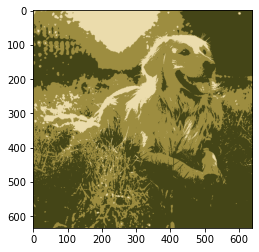

In [8]:
# Python program to explain cv2.imread() method

# importing cv2
import cv2

# path
path = r'C:\Users\Shulu\OneDrive\Skrivbord\golden-retriever-royalty-free-image-506756303-1560962726.jpg'

# Using cv2.imread() method
img = cv2.imread(path)

print(img.shape)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
    
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
centers = np.uint8(centers)

labels = labels.flatten()
    
segmented_image = centers[labels.flatten()]
    
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.show()